# import the important needs

In [2]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score



# Pipeline for Preprocessing Input Features and Target Feature

This pipeline includes the following preprocessing steps:

## Input Features
1. **Normalization for Income**: 
   - Scaling the income values to a range between 0 and 1.
   
2. **Boolean Conversion**: 
   - Converting the string values "Yes" and "No" to numerical values 1 and 0 in the columns `Own_Car` and `Own_Housing`.

3. **One-Hot Encoding for Gender**: 
   - Applying one-hot encoding to the `Gender` column, as encoding gender as just 0 and 1 may not fairly represent the contribution of each category.

## Target Feature
- **Target Conversion**: 
   - Mapping the string values "Approved" to 1 and "Denied" to 0 in the target feature.


In [4]:
class BooleanConverter(BaseEstimator, TransformerMixin):
    """Convert boolean columns ('Yes'/'No') to 1/0."""
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].map({'Yes': 1, 'No': 0})
        return X

class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    """Custom MinMaxScaler that scales data to a specified range."""
    def __init__(self):
        self.data_min = 30000
        self.data_max = 119999
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Scale data between 0 and 1 based on data min and max
        scaled_data = (X - self.data_min) / (self.data_max - self.data_min)
        return scaled_data

class DataPreprocessingPipeline:
    """Pipeline for feature preprocessing."""
    def __init__(self):
        self.pipeline = Pipeline(steps=[
            ('normalization', ColumnTransformer(transformers=[
                ('normalize_income', CustomMinMaxScaler(), ['Income']),
                ('convert_booleans', BooleanConverter(columns=['Own_Car', 'Own_Housing']), ['Own_Car', 'Own_Housing']),
                ('one_hot_gender', OneHotEncoder(), ['Gender'])  # Keep all categories for Gender
            ], remainder='passthrough'))
        ])
    
    def fit_transform(self, df):
        return self.pipeline.fit_transform(df)

class TargetPreprocessingPipeline:
    """Pipeline for target preprocessing."""
    def __init__(self):
        pass
    
    def fit_transform(self, y):
        return y.map({'Denied': 0, 'Approved': 1})



# Create ModelManager to help in saving  and loading the best model

In [7]:
class ModelManager:
    def __init__(self, directory=""):
        self.directory = directory  
    
    def save_models_separately(self, best_models):
        for entry in best_models:
            model_name = entry['model'].__class__.__name__  # Get the model's class name
            filename = os.path.join(self.directory, f"{model_name}_best_model.pkl")  # Create the filepath
            with open(filename, 'wb') as file:
                pickle.dump(entry, file)  # Save the model and its parameters in a pickle file
            print(f"Saved {model_name} to {filename}")
    
    def load_model(self, model_name):
        filename = os.path.join(self.directory, f"{model_name}_best_model.pkl")
        print(f"Looking for {model_name} at {filename}")
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                model_data = pickle.load(file)  # Load the model and its parameters from a pickle file
            print(f"Loaded {model_name} from {filename}")
            return model_data
        else:
            print(f"No model file found for {model_name}")
            return None


# Model Prediction Pipeline Summary

The `ModelPredictionPipeline` class facilitates loading a pre-trained machine learning model from a pickle file and making predictions on new data. 


In [10]:
class ModelPredictionPipeline:
    def __init__(self, model_path):
        # Load the pre-trained model from the pickle file
        with open(model_path, 'rb') as file:
            model_data = pickle.load(file)
            self.model = model_data['model'] 
        self.feature_pipeline = DataPreprocessingPipeline()

    def predict(self, X):
        # Preprocess features
        X_transformed = self.feature_pipeline.fit_transform(X)
        feature_names = (['Income', 'Own_Car', 'Own_Housing','Gender_Female','Gender_Male','Num_Children'])
        X_transformed=pd.DataFrame(X_transformed, columns=feature_names)

        # Make predictions using the pre-trained model
        return self.model.predict(X_transformed)

# load the orginal dataset

In [13]:
data_path= 'credit_card_train.csv'
df=pd.read_csv(data_path)
df.head(2)

,Num_Children,Gender,Income,Own_Car,Own_Housing,Credit_Card_Issuing
0,1,Male,40690,No,Yes,Denied
1,2,Female,75469,Yes,No,Denied


# Use the DataPreprocessingPipeline to do the preprocessing step for both input and target features

In [16]:
# Create instances of preprocessing pipelines
feature_pipeline = DataPreprocessingPipeline()
target_pipeline = TargetPreprocessingPipeline()

feature_names = (['Income', 'Own_Car', 'Own_Housing','Gender_Female','Gender_Male','Num_Children'])# Prepare features and target
X = df.drop('Credit_Card_Issuing', axis=1)  # Features
y = df['Credit_Card_Issuing']  # Target

# Apply feature preprocessing
X_processed = feature_pipeline.fit_transform(X)
X_processed=pd.DataFrame(X_processed, columns=feature_names)

# Apply target preprocessing
y_processed = target_pipeline.fit_transform(y)
y_processed=pd.DataFrame(y_processed, columns=['Credit_Card_Issuing'])

In [18]:
X_processed.head(2)

,Income,Own_Car,Own_Housing,Gender_Female,Gender_Male,Num_Children
0,0.118779,0.0,1.0,0.0,1.0,1.0
1,0.505217,1.0,0.0,1.0,0.0,2.0


In [20]:
y_processed.head(2)

,Credit_Card_Issuing
0,0
1,0


# Split the data into train,test and validation

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split( X_train_val, y_train_val, test_size=0.1/ (1 - 0.2), random_state=42 )

# Model Fairness Check

To ensure that the model accounts for fairness, we evaluated the gender distribution (percentage of females and males) in the training, testing, and validation datasets.

## Process:

- **Gender Distribution Analysis**: 
  - We calculated the percentage of females and males in each dataset.
  
- **Weighting Strategy**:
  - If any dataset exhibited a significant imbalance in gender representation, we would implement a weighting function to assign higher weights to the underrepresented group.
  
- **Outcome**:
  - Fortunately, all datasets maintain an approximately equal number of females and males, eliminating the need for additional weighting adjustments.


In [26]:
# Function to calculate gender percentages
def calculate_gender_percentages(df):
    total_females = df['Gender_Female'].sum()
    total_males = df['Gender_Male'].sum()
    total_population = total_females + total_males
    
    percentage_female = (total_females / total_population) * 100 if total_population > 0 else 0
    percentage_male = (total_males / total_population) * 100 if total_population > 0 else 0
    
    return percentage_female, percentage_male

# Calculate percentages for each set
train_percentage_female, train_percentage_male = calculate_gender_percentages(X_train)
val_percentage_female, val_percentage_male = calculate_gender_percentages(X_val)
test_percentage_female, test_percentage_male = calculate_gender_percentages(X_test)

# Output the results
print(f"Training Set - Percentage of Females: {train_percentage_female:.2f}%, Percentage of Males: {train_percentage_male:.2f}%")
print(f"Validation Set - Percentage of Females: {val_percentage_female:.2f}%, Percentage of Males: {val_percentage_male:.2f}%")
print(f"Test Set - Percentage of Females: {test_percentage_female:.2f}%, Percentage of Males: {test_percentage_male:.2f}%")


Training Set - Percentage of Females: 49.94%, Percentage of Males: 50.06%
Validation Set - Percentage of Females: 49.57%, Percentage of Males: 50.43%
Test Set - Percentage of Females: 50.06%, Percentage of Males: 49.94%


# Ensuring the Model Handles Variance and Bias Factors

To ensure that the model effectively manages both variance and bias factors, we employed the following strategies:

1. **Cross-Validation for Variance**: 
   - We utilized cross-validation to assess how the model's performance varies across different subsets of the data. This helps in understanding how well the model generalizes to unseen data, thereby addressing the variance factor.

2. **Accuracy for Bias**: 
   - We measured accuracy as a metric to evaluate the model's performance. This allows us to understand how well the model predicts the true labels, helping us to identify and address any potential bias in the model's predictions.

By combining these approaches, we ensure a robust evaluation of our model's performance, taking into account both variance and bias.


In [29]:
models = [
    {
        'model': LogisticRegression(),
        'parms': {  
            'max_iter': [50, 100]
        }
    },
    {
        'model': SVC(),
        'parms': {
            'C': [0.1, 1],
            'kernel': ['linear', 'poly']  
        }
    },
    {
        'model': XGBClassifier(),
        'parms': {
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    {
        'model': RandomForestClassifier(),
        'parms': {
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        }
    }
]

def grid_search_for_models(X_train, y_train, models, n_iter=8, random_state=42):
    best_model_for_each_model = []  
    for entry in models:
        model = entry['model']
        parms = entry['parms']
        
        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=parms, scoring='accuracy', cv=5)

        # Fit the model with random search (using ravel to ensure y_train is 1D)
        grid_search.fit(X_train, y_train.values.ravel())

        # Get the best model and its parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_model_for_each_model.append({'model': best_model, 'params': best_params})
        print(f"Best Model: {best_model.__class__.__name__}, Best Params: {best_params}")

    return best_model_for_each_model

# Call the function to get the best models
best_models = grid_search_for_models(X_train, y_train, models)

# Output best models and parameters
for entry in best_models:
    print(f"Best Model: {entry['model'].__class__.__name__}, Best Params: {entry['params']}")

Best Model: LogisticRegression, Best Params: {'max_iter': 50}
Best Model: SVC, Best Params: {'C': 0.1, 'kernel': 'linear'}
Best Model: XGBClassifier, Best Params: {'learning_rate': 0.1, 'max_depth': 5}
Best Model: RandomForestClassifier, Best Params: {'max_depth': 10, 'min_samples_split': 5}
Best Model: LogisticRegression, Best Params: {'max_iter': 50}
Best Model: SVC, Best Params: {'C': 0.1, 'kernel': 'linear'}
Best Model: XGBClassifier, Best Params: {'learning_rate': 0.1, 'max_depth': 5}
Best Model: RandomForestClassifier, Best Params: {'max_depth': 10, 'min_samples_split': 5}


# Saving the Best Models 

In [31]:
manager = ModelManager()
manager.save_models_separately(best_models)

Saved LogisticRegression to LogisticRegression_best_model.pkl
Saved SVC to SVC_best_model.pkl
Saved XGBClassifier to XGBClassifier_best_model.pkl
Saved RandomForestClassifier to RandomForestClassifier_best_model.pkl


# loading the Best Models

In [33]:
manager = ModelManager()
# Load each model by its name
logistic_regression_data = manager.load_model('LogisticRegression')
svc_data = manager.load_model('SVC')
xgb_classifier_data = manager.load_model('XGBClassifier')
random_forest_data = manager.load_model('RandomForestClassifier')

Looking for LogisticRegression at LogisticRegression_best_model.pkl
Loaded LogisticRegression from LogisticRegression_best_model.pkl
Looking for SVC at SVC_best_model.pkl
Loaded SVC from SVC_best_model.pkl
Looking for XGBClassifier at XGBClassifier_best_model.pkl
Loaded XGBClassifier from XGBClassifier_best_model.pkl
Looking for RandomForestClassifier at RandomForestClassifier_best_model.pkl
Loaded RandomForestClassifier from RandomForestClassifier_best_model.pkl


# Model Selection part
after we did the previous steps , we need to select which is best one from the best models

In [35]:
models_data = {
    'Logistic Regression': logistic_regression_data,
    'SVC': svc_data,
    'XGBClassifier': xgb_classifier_data,
    'RandomForestClassifier': random_forest_data
}

# Drawing the ROC Curve

The Receiver Operating Characteristic (ROC) curve is a valuable tool for evaluating the performance of classification models. The model with the largest area under the ROC curve (AUC) is considered the best model, as it indicates a higher true positive rate while maintaining a low false positive rate.

In this case, however, we observed that the AUC values for the models are almost identical, suggesting that they have similar performance levels. This finding highlights the need for further evaluation or consideration of additional metrics to distinguish between the models effectively.


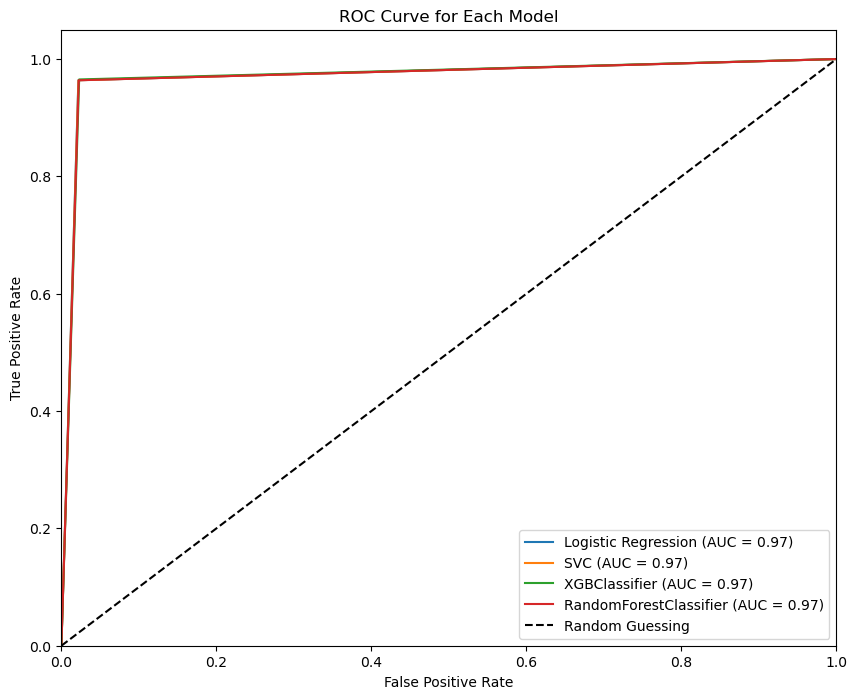

In [37]:
plt.figure(figsize=(10, 8))
for model_name, data in models_data.items():
    model = data['model']
    y_pred=model.predict(X_test)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Model")
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix Analysis

When examining the confusion matrices, we found that the results across models are almost identical. However, in our specific case, the priority is to avoid approving credit applications that should be denied. Therefore, our primary concern is minimizing false positives (FP).

Given this focus, the best-performing model is the one with the lowest number of false positives. In this analysis, Logistic Regression emerged as the top model, as it demonstrated the least amount of false positives among the evaluated classifiers.


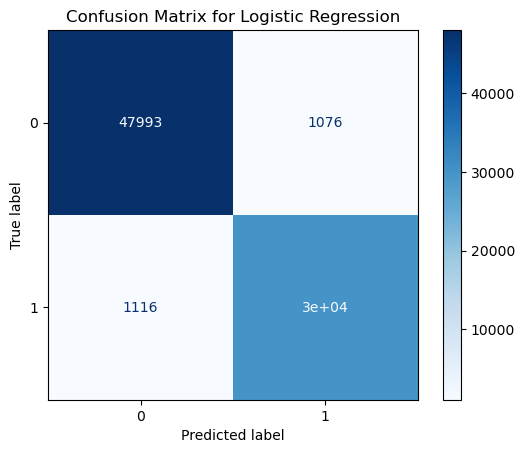

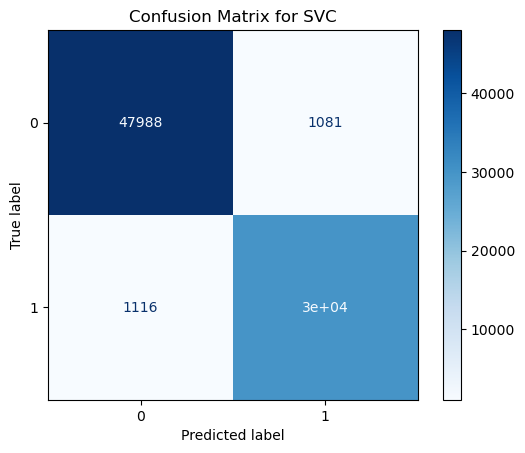

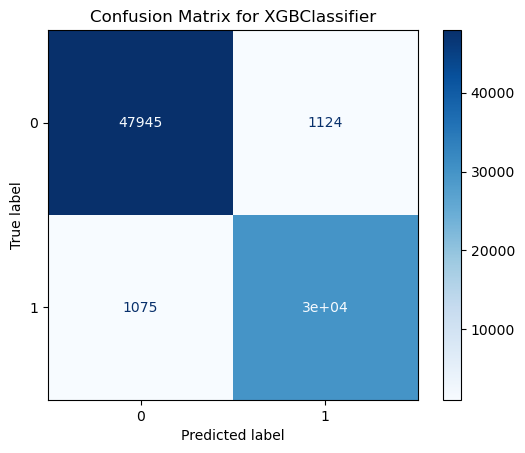

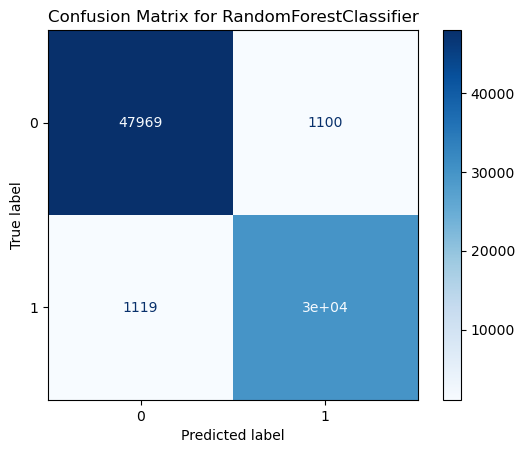

In [39]:
for model_name, data in models_data.items():
    model = data['model']  # Loaded model

    # Predict class labels for the test set
    y_pred = model.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


# Error Analysis by Gender

To evaluate fairness in our models, we conducted an error analysis segmented by gender. The results indicate that the models exhibit nearly identical error rates for both male and female participants. This suggests that the models handle gender-related predictions equitably, with no significant bias towards either gender type.


In [40]:

# Create a DataFrame to store error rates per gender for each model
error_rates = {}

for model_name, data in models_data.items():
    model = data['model']  # Loaded model
    
    # Get predictions from the model
    y_pred = model.predict(X_test)

    # Ensure that y_test is a 1D array
    y_test_flat = y_test.values.flatten()  
    y_pred_flat = y_pred.flatten() 
    
    # Create a DataFrame to hold true values, predictions, and gender
    gender_column = df.loc[y_test.index, 'Gender']  
    if gender_column.ndim > 1:
        gender_column = gender_column.values.flatten()  

    # Create results DataFrame
    results_df = pd.DataFrame({
        'True Labels': y_test_flat, 
        'Predictions': y_pred_flat,  
        'Gender': gender_column  
    })
    
    # Calculate the error (1 - correct predictions)
    results_df['Error'] = results_df['True Labels'] != results_df['Predictions']
    
    # Calculate error rates per gender
    error_rate_per_gender = results_df.groupby('Gender')['Error'].mean().reset_index()
    
    # Rename the columns for clarity
    error_rate_per_gender.columns = ['Gender', 'Error Rate']
    
    # Store the results in the dictionary
    error_rates[model_name] = error_rate_per_gender

# Display the error rates for each model
for model_name, error_rate in error_rates.items():
    print(f"Error rates for {model_name}:")
    print(error_rate)
    print()  


Error rates for Logistic Regression:
   Gender  Error Rate
0  Female    0.028693
1    Male    0.026104

Error rates for SVC:
   Gender  Error Rate
0  Female    0.028818
1    Male    0.026104

Error rates for XGBClassifier:
   Gender  Error Rate
0  Female    0.028718
1    Male    0.026255

Error rates for RandomForestClassifier:
   Gender  Error Rate
0  Female    0.028992
1    Male    0.026480





### Model Interpretability: Feature Importance Scores

#### 1. Logistic Regression
- **Income** is the most significant feature (56.63), while **Gender_Female** and **Gender_Male** have negative importance, indicating potential bias. This model is highly interpretable due to its clear feature importance values.

#### 2. SVC
- **Income** dominates (26.41), with both gender features showing negative importance. However, SVC generally offers less interpretability compared to linear models.

#### 3. XGBoost Classifier
- **Income** remains important (0.58), and **Gender_Female** has a positive score (0.28). While this model provides some interpretability, it is more complex and less transparent than logistic regression.

#### 4. Random Forest Classifier
- **Income** is crucial (0.84), with minimal contributions from gender features. This model is less interpretable because of its ensemble nature, making it harder to discern feature impact clearly.

### Conclusion
**Logistic Regression** offers the highest interpretability, followed by **SVC** and **XGBoost**, with **Random Forest** being the least interpretable due to its complexity.7406
5   Num_Children    0.000755

In [45]:
# Create a DataFrame to store feature importances for each model
feature_importances = {}

# Loop through each model to get feature importances
for model_name, data in models_data.items():
    model = data['model']  # Loaded model

    # Calculate feature importances
    if hasattr(model, 'coef_'):  # For Logistic Regression and SVC with linear kernel
        feature_importances[model_name] = model.coef_[0] 
    elif hasattr(model, 'feature_importances_'):  # For Random Forest and XGBoost
        feature_importances[model_name] = model.feature_importances_
    else:
        # For SVC with non-linear kernel, use permutation importance
        result = permutation_importance(model, X_test, y_test.values.flatten(), n_repeats=10, random_state=42)
        feature_importances[model_name] = result.importances_mean

# Display feature importances for each model
for model_name, importance in feature_importances.items():
    print(f"Feature importances for {model_name}:")
    if isinstance(importance, np.ndarray):
        importance_df = pd.DataFrame({
            'Feature': X_test.columns,  
            'Importance': importance
        })
        print(importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True))
    else:
        print("No importance score available.")
    print()  


Feature importances for Logistic Regression:
         Feature  Importance
0         Income   56.626187
1    Own_Housing    4.420723
2        Own_Car    1.913403
3   Num_Children   -0.001828
4    Gender_Male   -8.355581
5  Gender_Female  -14.650782

Feature importances for SVC:
         Feature  Importance
0         Income   26.413798
1    Own_Housing    2.071554
2    Gender_Male    1.467956
3        Own_Car    0.903336
4   Num_Children   -0.002890
5  Gender_Female   -1.467956

Feature importances for XGBClassifier:
         Feature  Importance
0         Income    0.584681
1  Gender_Female    0.284466
2    Own_Housing    0.096817
3        Own_Car    0.033657
4   Num_Children    0.000380
5    Gender_Male    0.000000

Feature importances for RandomForestClassifier:
         Feature  Importance
0         Income    0.846550
1  Gender_Female    0.072065
2    Gender_Male    0.042168
3    Own_Housing    0.031146
4        Own_Car    0.007294
5   Num_Children    0.000777



# final selection is 
the LogisticRegression_best_model.pkl
# example to how to use model_pipeline

In [55]:
data_path= 'credit_card_train.csv'
df=pd.read_csv(data_path)
feature_names = (['Income', 'Own_Car', 'Own_Housing','Gender','Num_Children'])
X = df.drop('Credit_Card_Issuing', axis=1)  
y = df['Credit_Card_Issuing']  
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test=X_test[feature_names]

In [57]:
model_pipeline = ModelPredictionPipeline('LogisticRegression_best_model.pkl')
# Make predictions using the model pipeline
predictions = model_pipeline.predict(X_test)

# Apply target preprocessing to y_test
y_test = target_pipeline.fit_transform(y_test)
y_test = pd.DataFrame(y_test, columns=['Credit_Card_Issuing'])

# Ensure that y_test is a 1D array for metrics calculations
y_test_values = y_test['Credit_Card_Issuing'].values

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test_values, predictions)
precision = precision_score(y_test_values, predictions)
recall = recall_score(y_test_values, predictions)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

#  print a classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_test_values, predictions))


Accuracy: 0.9726
Precision: 0.9652
Recall: 0.9639

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     49069
           1       0.97      0.96      0.96     30931

    accuracy                           0.97     80000
   macro avg       0.97      0.97      0.97     80000
weighted avg       0.97      0.97      0.97     80000

